In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../Work/Abstract/PaperBin/AllThreeSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['allThreeYesWrat']
    groups = splits['groups']
    
print(len(subids))

593


In [2]:
import numpy as np

subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', 'rest', meta[subid]['rest']) for subid in subidsNp]
# nback_ts = [loadSeries('../../PNC', 'nback', meta[subid]['nback']) for subid in subidsNp]
# emoid_ts = [loadSeries('../../PNC', 'emoid', meta[subid]['emoid']) for subid in subidsNp]

print('Loading complete')

Loading complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(rest_ts)
# normalizeSubjects(nback_ts)
# normalizeSubjects(emoid_ts)

print('Complete')

Complete


In [4]:
print(rest_ts[0].shape)

(264, 124)


In [165]:
# Simple model

nRoi = rest_ts[0].shape[0]
nHid = 100

import torch 
import torch.nn as nn
import torch.nn.functional as F

class SimpleMarkov(nn.Module):
    def __init__(self):
        super(SimpleMarkov, self).__init__()
        self.fc1 = nn.Linear(nRoi,nRoi).cuda()
        
    def forward(self, x):
        y = torch.zeros(x.shape).cuda()
        y[1:] = self.fc1(x[0:-1])
        return y
    
# Train

res = dict()
recon = dict()
nets = dict()
nEpoch = 2000
nPrint = 1000
nSub = 20
nLoop = 3

for loop in range(0,nLoop):
    print(f'loop {loop}')
    for subj_idx in range(0,nSub):
        print(f'\tsubject {subj_idx}')
        subj = rest_ts[subj_idx]
        subj_perm = torch.from_numpy(subj).float().permute(1,0).cuda()
        if subj_idx not in nets:
            net = SimpleMarkov()
        else:
            net = nets[subj_idx]
        optim = torch.optim.Adam(net.parameters(), lr=1e-3)
        running_loss = 0
        running_window = 0
        average_weight = torch.zeros(nRoi,nRoi).cuda()
        average_bias = torch.zeros(nRoi).cuda()
        if len(nets) == nSub:
            for avgnet in nets.values():
                average_weight += avgnet.fc1.weight.detach()/nSub
                average_bias += avgnet.fc1.bias.detach()/nSub
        for epoch in range(0,nEpoch):
            optim.zero_grad()
            subj_recon = net(subj_perm)
            subj_res = subj_recon - subj_perm
            loss_recon = torch.sum(subj_res**2)
            loss_sparse = torch.sum(torch.abs(net.fc1.weight)) + torch.sum(torch.abs(net.fc1.bias))
            if len(nets) == nSub:
                loss_diff = torch.sum((net.fc1.weight-average_weight)**2) + torch.sum((net.fc1.bias-average_bias))
            else:
                loss_diff = 0
            loss = loss_recon + 0*loss_sparse + 100*loss_diff
            loss.backward()
            optim.step()
            running_loss += loss.cpu().detach()
            running_window += 1
            if epoch % nPrint == 0 or epoch == nEpoch - 1:
                print(f'\t\tepoch {epoch} loss {running_loss/running_window}')
                running_loss = 0
                running_window = 0
        recon[subj_idx] = subj_recon.cpu().detach().numpy()
        res[subj_idx] = subj_res.cpu().detach().numpy()
        nets[subj_idx] = net

loop 0
	subject 0
		epoch 0 loss 43442.61328125
		epoch 1000 loss 1492.230712890625
		epoch 1999 loss 60.54935836791992
	subject 1
		epoch 0 loss 43999.2265625
		epoch 1000 loss 1356.0670166015625
		epoch 1999 loss 69.6543197631836
	subject 2
		epoch 0 loss 43174.02734375
		epoch 1000 loss 2585.72314453125
		epoch 1999 loss 163.40530395507812
	subject 3
		epoch 0 loss 43507.8671875
		epoch 1000 loss 1141.453369140625
		epoch 1999 loss 93.80091094970703
	subject 4
		epoch 0 loss 43222.08203125
		epoch 1000 loss 2632.19287109375
		epoch 1999 loss 193.67025756835938
	subject 5
		epoch 0 loss 43326.12109375
		epoch 1000 loss 2289.237548828125
		epoch 1999 loss 209.90357971191406
	subject 6
		epoch 0 loss 43982.7578125
		epoch 1000 loss 2267.39404296875
		epoch 1999 loss 215.226806640625
	subject 7
		epoch 0 loss 43132.11328125
		epoch 1000 loss 1402.46630859375
		epoch 1999 loss 69.793701171875
	subject 8
		epoch 0 loss 43427.67578125
		epoch 1000 loss 1302.5535888671875
		epoch 1999 loss 

In [181]:
nets[0].fc1.weight

Parameter containing:
tensor([[ 0.2263,  0.1147,  0.0134,  ...,  0.0062, -0.0086, -0.0468],
        [ 0.1374,  0.2186, -0.0090,  ...,  0.0528, -0.0152, -0.0780],
        [ 0.0364, -0.0118,  0.1815,  ...,  0.0084,  0.0153,  0.0459],
        ...,
        [ 0.0612,  0.0593, -0.0147,  ...,  0.1528,  0.0226, -0.0416],
        [ 0.0213, -0.0147,  0.0116,  ..., -0.0153,  0.1416, -0.0179],
        [ 0.0170,  0.0442,  0.0424,  ...,  0.0084, -0.0152,  0.1353]],
       device='cuda:0', requires_grad=True)

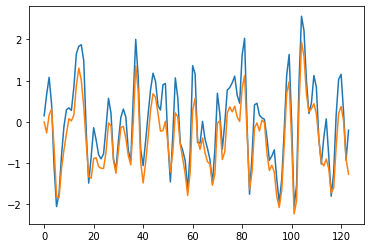

In [172]:
import matplotlib.pyplot as plt

plt.plot(rest_ts[10][100])
plt.plot(recon[10][:,100])
plt.show()

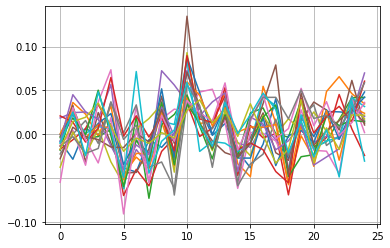

In [179]:
for i in range(0,nSub):
    plt.plot(nets[i].fc1.weight[0,175:200].cpu().detach().numpy())
plt.grid(True)
plt.show()

[[1.         0.52579425 0.54807134 0.51748754 0.53755388 0.53642173
  0.55325996 0.55099506 0.55702925 0.55911241 0.57036401 0.56020739
  0.57099097 0.5891405  0.54645348 0.58474378 0.57573728 0.5723034
  0.58577445 0.5803217 ]
 [0.52579425 1.         0.54658187 0.51777996 0.54153265 0.53668892
  0.55352641 0.55514428 0.56307339 0.55656616 0.57757904 0.56778544
  0.58368117 0.5821696  0.55426088 0.58001099 0.56992028 0.58208372
  0.58361272 0.58128926]
 [0.54807134 0.54658187 1.         0.53545678 0.56245264 0.53258472
  0.56295517 0.57248501 0.56685782 0.57156506 0.59854964 0.57614296
  0.60020727 0.61039666 0.5612541  0.5973136  0.58981958 0.57770758
  0.59000012 0.60983531]
 [0.51748754 0.51777996 0.53545678 1.         0.52409134 0.54015566
  0.53650847 0.54022471 0.54268401 0.53713971 0.56244203 0.55134899
  0.56461961 0.56738029 0.55146237 0.57110248 0.56084348 0.55914163
  0.5754728  0.58262412]
 [0.53755388 0.54153265 0.56245264 0.52409134 1.         0.55651142
  0.53029193 0.55

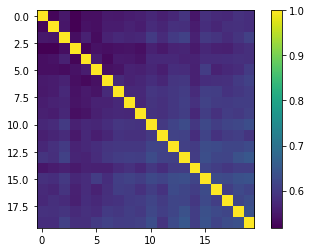

In [180]:
w0 = np.zeros([nSub,nRoi*nRoi])
for i in range(0,nSub):
    w0[i] = nets[i].fc1.weight.cpu().detach().numpy().flatten()
mat = np.corrcoef(w0)
print(mat)
plt.imshow(mat)
plt.colorbar()
plt.show()

In [50]:
from sklearn import linear_model

def create_xy(rest_ts, nSub):
    nRoi = rest_ts[0].shape[0]
    nt = rest_ts[0].shape[1]
    y = np.zeros(nSub*nRoi*(nt-1) + nSub*nRoi*nRoi)
    X = np.zeros([nSub*nRoi*(nt-1) + nSub*nRoi*nRoi, nSub*nRoi*nRoi])
    sim_block = np.eye(nRoi*nRoi)
    for i in range(0,nSub):
        sIdx = i*nRoi*(nt-1)
        eIdx = (i+1)*nRoi*(nt-1)
        y[sIdx:eIdx] = rest_ts[i][:,1:].reshape(eIdx-sIdx)
        X[sIdx:eIdx] = np.repeat(rest_ts[i][:,0:-1], nRoi, axis=0).T
        sim_sIdx = nSub*nRoi*(nt-1) + i*nRoi*nRoi
        sim_eIdx = nSub*nRoi*(nt-1) + (i+1)*nRoi*nRoi
        X[sim_sIdx:sim_eIdx,0:nRoi*nRoi] = sim_block
        X[sim_sIdx:sim_eIdx,i*nRoi*nRoi:(i+1)*nRoi*nRoi] = -sim_block
    return X,y

X,y = create_xy(rest_ts, 10)
clf = linear_model.Lasso()

clf.fit(X,y)

MemoryError: Unable to allocate 5.18 TiB for an array with shape (1021680, 696960) and data type float64